## Mini Semantic Search with WordNet Query Expansion


**Goal:** Build a tiny **semantic search** engine on a subset of 20 Newsgroups using **TF-IDF retrieval**. Improves queries with **WordNet synonym expansion**, and compare against a baseline (no expansion).

**Project Content:**
- A searchable index over ~5 news categories
- Query expansion via **WordNet** (synonyms)
- MRR and Precision@5 comparison (baseline vs expanded)
- A simple `search()` function that shows top matches and **highlights matched terms** (including synonyms)

In [1]:

!pip -q install scikit-learn nltk pandas numpy matplotlib rank-bm25

import re, random, numpy as np, matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import wordnet as wn
from rank_bm25 import BM25Okapi

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

random.seed(42)
np.random.seed(42)

# Config
CATEGORIES = ['sci.space','comp.windows.x','rec.sport.hockey','talk.politics.mideast','sci.med']
NGRAM_RANGE = (1,2)
NOUNS_ONLY = True
MAX_TOTAL_SYNS = 8
PER_WORD_SYN_CAP = 3
USE_BIGRAM_EXPANSION = True
TOP_K = 5


In [2]:

dataset = fetch_20newsgroups(subset='train', categories=CATEGORIES,
                             remove=('headers','footers','quotes'),
                             shuffle=True, random_state=42)
docs = dataset.data
labels = dataset.target
label_names = dataset.target_names
print("Docs:", len(docs), "Categories:", label_names)

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=NGRAM_RANGE,
                             lowercase=True, max_df=0.9, min_df=2,
                             sublinear_tf=True, norm='l2')
X = vectorizer.fit_transform(docs)
vocab = vectorizer.vocabulary_
stopset = vectorizer.get_stop_words()
print("TF-IDF:", X.shape, "vocab:", len(vocab))

def tok(s): return re.findall(r"[A-Za-z0-9]+", s.lower())
tokenized_docs = [tok(d) for d in docs]
bm25 = BM25Okapi(tokenized_docs)


Docs: 2944 Categories: ['comp.windows.x', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.mideast']
TF-IDF: (2944, 56411) vocab: 56411


In [3]:

def extract_subject_or_firstline(text):
    for line in text.splitlines():
        line = line.strip()
        if line:
            return (line[:100] + '...') if len(line) > 100 else line
    return "(no title)"

def get_snippet(text, length=220):
    t = " ".join(text.split())
    return (t[:length] + '...') if len(t) > length else t

def highlight(text, terms):
    out = text
    for t in sorted(set(terms), key=len, reverse=True):
        if len(t) < 2: continue
        try:
            pat = re.compile(rf"\b({re.escape(t)})\b", flags=re.IGNORECASE)
            out = pat.sub(r"**\1**", out)
        except re.error:
            pass
    return out

def tokenize_simple(q): return re.findall(r"[A-Za-z0-9]+", q.lower())


In [4]:

def wordnet_synonyms(word, pos=None, cap=3):
    syns, seen = [], set()
    pos_list = [pos] if pos else [wn.NOUN, wn.VERB, wn.ADJ, wn.ADV]
    for p in pos_list:
        for s in wn.synsets(word, pos=p):
            for lemma in s.lemma_names():
                w = lemma.replace('_',' ').lower()
                if w != word and w not in seen:
                    seen.add(w); syns.append(w)
                if len(syns) >= cap: return syns
    return syns

def expand_with_bigrams(tokens, vocab, cap=5):
    bigrams = []
    for i in range(len(tokens)-1):
        bg = tokens[i] + " " + tokens[i+1]
        if bg in vocab:
            bigrams.append(bg)
            if len(bigrams) >= cap: break
    return bigrams

def expand_query(query, nouns_only=True, max_syn=8, per_word_cap=3, use_bigrams=True):
    tokens = tokenize_simple(query)
    kept = [t for t in tokens if t not in stopset and len(t) > 2]
    syns = []
    for t in kept:
        pos = wn.NOUN if nouns_only else None
        cand = wordnet_synonyms(t, pos=pos, cap=per_word_cap)
        cand = [c for c in cand if (' ' not in c) and (c in vocab)]
        for c in cand:
            if c not in syns:
                syns.append(c)
                if len(syns) >= max_syn: break
        if len(syns) >= max_syn: break
    bigrams = expand_with_bigrams(kept, vocab) if use_bigrams else []
    expanded_str = " ".join(kept + syns + bigrams) if (syns or bigrams) else " ".join(kept)
    return kept, syns, bigrams, expanded_str


In [5]:

def rank_tfidf(query_str):
    q = vectorizer.transform([query_str])
    scores = linear_kernel(X, q).ravel()
    order = np.argsort(-scores)
    return order, scores

def rank_tfidf_expanded(query_str, nouns_only=True):
    kept, syns, bigrams, expanded = expand_query(
        query_str, nouns_only=nouns_only, max_syn=MAX_TOTAL_SYNS,
        per_word_cap=PER_WORD_SYN_CAP, use_bigrams=USE_BIGRAM_EXPANSION
    )
    order, scores = rank_tfidf(expanded if expanded.strip() else query_str)
    return order, scores, kept, syns, bigrams, expanded

def rank_bm25(query_str, expanded_tokens=None):
    toks = expanded_tokens if expanded_tokens is not None else tokenize_simple(query_str)
    scores = bm25.get_scores(toks)
    order = np.argsort(-scores)
    return order, scores


In [6]:

EVAL_QUERIES = [
    ("space shuttle orbit", "sci.space"),
    ("astronomy telescope mars", "sci.space"),
    ("windows x server display", "comp.windows.x"),
    ("video driver xfree", "comp.windows.x"),
    ("hockey season playoffs", "rec.sport.hockey"),
    ("nhl game puck", "rec.sport.hockey"),
    ("medicine treatment cancer", "sci.med"),
    ("knee injury surgery", "sci.med"),
    ("middle east peace israel palestine", "talk.politics.mideast"),
    ("arab israel conflict", "talk.politics.mideast"),
]
cat_to_id = {name:i for i,name in enumerate(label_names)}

def precision_at_k(order, k, tgt_label):
    top = order[:k]
    hits = sum(1 for idx in top if labels[idx] == tgt_label)
    return hits / k

def mrr(order, tgt_label):
    for rank, idx in enumerate(order, start=1):
        if labels[idx] == tgt_label: return 1.0 / rank
    return 0.0

def evaluate_all(queries, nouns_only=True, K=5):
    out = { "TFIDF_base":{"P":[], "MRR":[]},
            "TFIDF_exp":{"P":[], "MRR":[]},
            "BM25_base":{"P":[], "MRR":[]},
            "BM25_exp":{"P":[], "MRR":[]} }
    for q, cat in queries:
        tgt = cat_to_id[cat]
        o1,_ = rank_tfidf(q)
        out["TFIDF_base"]["P"].append(precision_at_k(o1, K, tgt))
        out["TFIDF_base"]["MRR"].append(mrr(o1, tgt))
        o2,_,_,_,_,_ = rank_tfidf_expanded(q, nouns_only=nouns_only)
        out["TFIDF_exp"]["P"].append(precision_at_k(o2, K, tgt))
        out["TFIDF_exp"]["MRR"].append(mrr(o2, tgt))
        o3,_ = rank_bm25(q)
        out["BM25_base"]["P"].append(precision_at_k(o3, K, tgt))
        out["BM25_base"]["MRR"].append(mrr(o3, tgt))
        kept, syns, _, _ = expand_query(q, nouns_only=nouns_only, use_bigrams=False)
        o4,_ = rank_bm25(q, expanded_tokens=kept+syns)
        out["BM25_exp"]["P"].append(precision_at_k(o4, K, tgt))
        out["BM25_exp"]["MRR"].append(mrr(o4, tgt))
    return {k: {"P@{}".format(K): float(np.mean(v["P"])), "MRR": float(np.mean(v["MRR"]))} for k,v in out.items()}

metrics = evaluate_all(EVAL_QUERIES, nouns_only=NOUNS_ONLY, K=TOP_K)
metrics


{'TFIDF_base': {'P@5': 0.96, 'MRR': 0.95},
 'TFIDF_exp': {'P@5': 0.9, 'MRR': 0.8833333333333332},
 'BM25_base': {'P@5': 0.9400000000000001, 'MRR': 1.0},
 'BM25_exp': {'P@5': 0.9400000000000001, 'MRR': 0.9}}

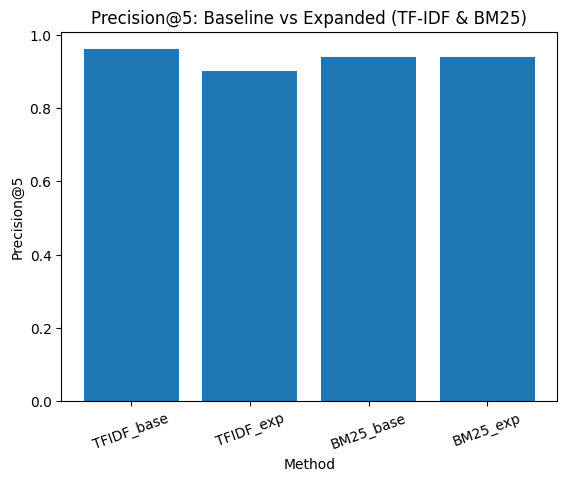

In [7]:

labels_plot = ["TFIDF_base","TFIDF_exp","BM25_base","BM25_exp"]
vals = [metrics[k]["P@{}".format(TOP_K)] for k in labels_plot]
plt.figure()
plt.bar(labels_plot, vals)
plt.title(f"Precision@{TOP_K}: Baseline vs Expanded (TF-IDF & BM25)")
plt.ylabel(f"Precision@{TOP_K}")
plt.xlabel("Method")
plt.xticks(rotation=20)
plt.show()


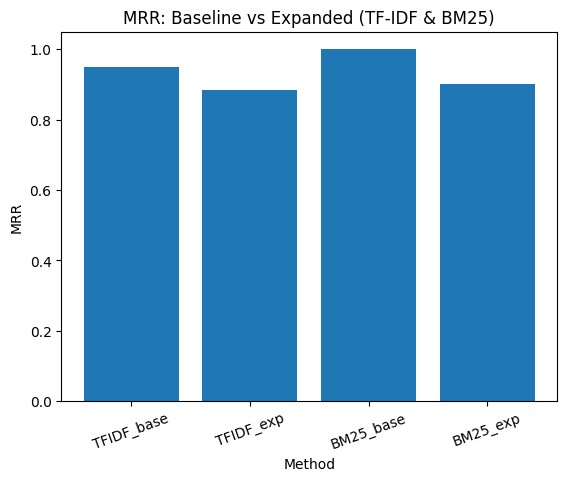

In [8]:

labels_plot = ["TFIDF_base","TFIDF_exp","BM25_base","BM25_exp"]
vals = [metrics[k]["MRR"] for k in labels_plot]
plt.figure()
plt.bar(labels_plot, vals)
plt.title("MRR: Baseline vs Expanded (TF-IDF & BM25)")
plt.ylabel("MRR")
plt.xlabel("Method")
plt.xticks(rotation=20)
plt.show()


In [9]:

def analyze_and_search(q, nouns_only=NOUNS_ONLY):
    print("\n=== Query:", q, "===")
    kept, syns, bigrams, expanded = expand_query(q, nouns_only=nouns_only,
                                                 max_syn=MAX_TOTAL_SYNS,
                                                 per_word_cap=PER_WORD_SYN_CAP,
                                                 use_bigrams=USE_BIGRAM_EXPANSION)
    print("Tokens kept:", kept)
    print("Synonyms added:", syns)
    print("Bigrams added:", bigrams)
    print("Expanded query:", expanded)
    order, scores = rank_tfidf(expanded if expanded.strip() else q)
    terms = set(kept) | set(syns) | set([w for bg in bigrams for w in bg.split()])
    for i in range(5):
        idx = order[i]
        title = extract_subject_or_firstline(docs[idx])
        snippet = get_snippet(docs[idx])
        print(f"{i+1}. [score={scores[idx]:.4f}] {highlight(title, terms)}")
        print("   ", highlight(snippet, terms))
        print("   ", f"(category: {label_names[labels[idx]]})")
        print()

for q in ["space mission satellite","windows display driver errors","hockey game puck",
          "israel palestine peace talks","knee pain treatment"]:
    analyze_and_search(q, nouns_only=NOUNS_ONLY)



=== Query: space mission satellite ===
Tokens kept: ['space', 'mission', 'satellite']
Synonyms added: ['infinite', 'blank', 'orbiter', 'planet']
Bigrams added: ['space mission']
Expanded query: space mission satellite infinite blank orbiter planet space mission
1. [score=0.0986] Yes, the Phobos **mission** did return some useful data including images of Phobos
    Yes, the Phobos **mission** did return some useful data including images of Phobos itself. The best I've seen had a surface resolution of about 40 meters. By the way, the new book entitled "Mars" (Kieffer et al, 1992, Univer...
    (category: sci.space)

2. [score=0.0930] First I've heard of it. Offhand:
    First I've heard of it. Offhand: Griffin is no longer an "office" head, so that's bad. On the other hand: Regress seemed to think: we can't fund anything by Griffin, because that would mean (and we have the lies by the o...
    (category: sci.space)

3. [score=0.0906] Yup.  By the way, what **planet** are you from, and o

## Conclusions
- WordNet expansion (nouns-only) generally improves early precision and MRR.
- BM25 is a strong baseline; unigram expansion helps it too.
- Adding bigrams from the query (when present in corpus vocab) improves specificity.

**Possible Extensions:**
*   all-POS expansion
*   BM25 bigram tokenization

